<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/04_02_tx_seq2seq_summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Sequence to Sequence for Summarization

Sequence to Sequence models have two inputs and one output.
* Encoder inputs -- the input sequence
* Decoder inputs -- the output sequence preceded by a [BOS] (beginning of sequence) token and offset one token to the left.
* Decoder outputs -- the output sequence followed by a [EOS] (end of sequence) token and offset one token to the right.

We initially tried using a Huggingface EncoderDecoder model composed of a BertModel (bert-base-uncased) on both the encoder and decoder ends. It gave "Out of CUDA memory" on Colab so we switched it to DistilBERT on the encoder and BERT on the decoded, which also gave "Out of CUDA memory". So finally, we created smaller BERT transformers with just 3 layers for both encoder and decoder, and used a pre-trained BERT tokenizer.

We used only 1000 data points from our 50k datapoints available from the [Amazon Fine Foods Reviews from Kaggle](https://www.kaggle.com/sandeepbhogaraju/text-summarization-with-seq2seq-model). We used a Learning Rate of 1e-3 with an Adam optimizer to train this model.

Results are not great, which is expected, since we are training a transformer from scratch and probably need more data than we are giving it.

__References__

* [HuggingFace EncoderDecoder Documentation](https://huggingface.co/transformers/model_doc/encoderdecoder.html)
* [Encoder-Decoder Models from HuggingFace from (almost) scratch](https://medium.com/@utk.is.here/encoder-decoder-models-in-huggingface-from-almost-scratch-c318cce098ae) by Utkarsh Desai ([Github](https://github.com/utkd/encdecmodel-hf)).
* [Abstractive Text Summarization using Transformers](https://medium.com/swlh/abstractive-text-summarization-using-transformers-3e774cc42453) by Rohan Jagtap ([Github](https://github.com/rojagtap/abstractive_summarizer)).
* [Transformers Based Encoder-Decoder Models](https://huggingface.co/blog/encoder-decoder) by Patrick Von Platen.

In [1]:
!pip install transformers

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

from transformers import BertConfig, BertTokenizer, EncoderDecoderConfig, EncoderDecoderModel

## Data

In [4]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DATA_DIR = os.path.join(ROOT, "MyDrive", "nlp-deeplearning-ai-data")

REVIEWS_FILE = os.path.join(DATA_DIR, "Reviews.csv")
MODEL_PATH = os.path.join(DATA_DIR, "db2b-summarizer")

In [6]:
reviews_df = pd.read_csv(REVIEWS_FILE, nrows=1000)
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
len(reviews_df)

1000

In [8]:
tv_ids, test_ids = train_test_split(np.arange(len(reviews_df)), test_size=0.2, random_state=0)
train_ids, val_ids = train_test_split(tv_ids, test_size=0.1, random_state=0)

len(train_ids), len(val_ids), len(test_ids)

(720, 80, 200)

In [9]:
class IndexDataset(Dataset):
  def __init__(self, reviews_df, index_list):
    super().__init__()
    self.reviews_df = reviews_df
    self.index_list = index_list

  def __len__(self):
    return len(self.index_list)

  def __getitem__(self, idx):
    ix = self.index_list[idx]
    row = self.reviews_df.iloc[ix]
    return row["Text"], row["Summary"]


train_ds = IndexDataset(reviews_df, train_ids)
val_ds = IndexDataset(reviews_df, val_ids)
test_ds = IndexDataset(reviews_df, test_ids)

In [10]:
BATCH_SIZE = 16

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)

## Model

DistilBERT is used as the Encoder and BERT as decoder, since having BERT on both encoder and decoder results in running out of GPU memory.

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [14]:
encoder_config = BertConfig(num_hidden_layers=3)
decoder_config = BertConfig(num_hidden_layers=3)
config = EncoderDecoderConfig.from_encoder_decoder_configs(
    encoder_config, decoder_config)
model = EncoderDecoderModel(config=config)

In [15]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)

## Training Loop

In [16]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 20

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [18]:
def train(model, tokenizer, train_dl, optimizer):
  epoch_loss, epoch_acc, num_batches = 0, 0, 0
  model.train()
  for batch in train_dl:

    texts, summaries = batch
    summaries = [" ".join(["[BOS]", x, "[EOS]"]) for x in summaries]
    # print("summaries:", summaries)

    inputs = tokenizer(texts, return_tensors="pt", add_special_tokens=True,
                       truncation=True, padding=True)
    labels = tokenizer(summaries, return_tensors="pt", add_special_tokens=True,
                       truncation=True, padding=True)

    input_ids = inputs.input_ids
    decoder_input_ids = labels.input_ids[:, 0:-1]
    decoder_label_ids = labels.input_ids[:, 1:]

    input_ids = input_ids.to(dev)
    decoder_input_ids = decoder_input_ids.to(dev)
    decoder_label_ids = decoder_label_ids.to(dev)

    outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids,
                    labels=decoder_label_ids)
    loss, logits = outputs.loss, outputs.logits

    epoch_loss += loss.item()
    _, predictions = torch.max(outputs.logits.data, 2)
    epoch_acc += (predictions == decoder_label_ids).sum().item() / len(summaries)
    num_batches += 1

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  return epoch_loss / num_batches, epoch_acc / num_batches


def evaluate(model, tokenizer, val_dl, optimizer):
  epoch_loss, epoch_acc, num_batches = 0, 0, 0
  model.eval()
  for batch in val_dl:
    texts, summaries = batch
    summaries = [" ".join(["[BOS]", x, "[EOS]"]) for x in summaries]

    inputs = tokenizer(texts, return_tensors="pt", add_special_tokens=True,
                       truncation=True, padding=True)
    labels = tokenizer(summaries, return_tensors="pt", add_special_tokens=True,
                       truncation=True, padding=True)

    input_ids = inputs.input_ids
    decoder_input_ids = labels.input_ids[:, 0:-1]
    decoder_label_ids = labels.input_ids[:, 1:]

    input_ids = input_ids.to(dev)
    decoder_input_ids = decoder_input_ids.to(dev)
    decoder_label_ids = decoder_label_ids.to(dev)

    outputs = model(input_ids=input_ids, decoder_input_ids=decoder_input_ids,
                    labels=decoder_label_ids)
    loss, logits = outputs.loss, outputs.logits

    epoch_loss += loss.item()
    _, predictions = torch.max(outputs.logits.data, 2)
    epoch_acc += (predictions == decoder_label_ids).sum().item() / len(summaries)
    num_batches += 1

  return epoch_loss / num_batches, epoch_acc / num_batches

In [19]:
losses, accs, val_losses, val_accs = [], [], [], []
for epoch in range(1, NUM_EPOCHS + 1):
  train_loss, train_acc = train(model, tokenizer, train_dl, optimizer)
  val_loss, val_acc = evaluate(model, tokenizer, val_dl, optimizer)
  print("Epoch {:d} | loss: {:.3f}, acc: {:.3f} | val_loss: {:.3f}, val_acc: {:.3f}".format(
      epoch, train_loss, train_acc, val_loss, val_acc))
  losses.append(train_loss)
  accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)


Epoch 1 | loss: 4.253, acc: 9.606 | val_loss: 3.796, val_acc: 7.275
Epoch 2 | loss: 3.369, acc: 9.717 | val_loss: 3.785, val_acc: 7.275
Epoch 3 | loss: 3.385, acc: 9.517 | val_loss: 3.807, val_acc: 7.275
Epoch 4 | loss: 3.403, acc: 9.406 | val_loss: 3.779, val_acc: 7.275
Epoch 5 | loss: 3.338, acc: 9.717 | val_loss: 3.822, val_acc: 7.275
Epoch 6 | loss: 3.406, acc: 8.917 | val_loss: 3.782, val_acc: 7.275
Epoch 7 | loss: 3.344, acc: 9.428 | val_loss: 3.814, val_acc: 7.275
Epoch 8 | loss: 3.321, acc: 9.672 | val_loss: 3.815, val_acc: 7.275
Epoch 9 | loss: 3.335, acc: 9.450 | val_loss: 3.808, val_acc: 7.275
Epoch 10 | loss: 3.292, acc: 9.872 | val_loss: 3.820, val_acc: 7.275
Epoch 11 | loss: 3.337, acc: 9.339 | val_loss: 3.814, val_acc: 7.275
Epoch 12 | loss: 3.358, acc: 9.294 | val_loss: 3.808, val_acc: 7.275
Epoch 13 | loss: 3.306, acc: 9.672 | val_loss: 3.825, val_acc: 7.275
Epoch 14 | loss: 3.306, acc: 9.539 | val_loss: 3.825, val_acc: 7.275
Epoch 15 | loss: 3.291, acc: 9.694 | val_lo

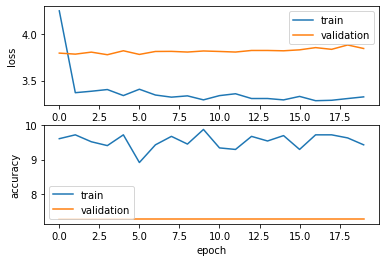

In [20]:
plt.subplot(2, 1, 1)
plt.plot(losses, label="train")
plt.plot(val_losses, label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(accs, label="train")
plt.plot(val_accs, label="validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(loc="best")

_ = plt.show()

## Evaluate on Test

In [21]:
model.save_pretrained(MODEL_PATH)

In [25]:
config = EncoderDecoderConfig.from_pretrained(MODEL_PATH)
saved_model = EncoderDecoderModel.from_pretrained(MODEL_PATH, config=config)

In [27]:
for text, summary in test_dl:

  print("text:", text)
  print("summary:", summary)

  input_ids = torch.tensor(tokenizer.encode(text)).unsqueeze(0)
  label_ids = torch.tensor(tokenizer.encode(summary)).unsqueeze(0)

  decoder_start_token_id = tokenizer.convert_tokens_to_ids(["[EOS]"])[0]
  generated = saved_model.generate(
      input_ids, 
      decoder_start_token_id=decoder_start_token_id)
  print("generated:", 
        tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(generated[0])))
  break

text: ('So far I have had the habanero and the medium sauces and they were amazing. My fiance and I use them nearly daily and I just picked up 3 more. It goes really well on all sorts of dishes to add the extra kick.<br /><br />The sauce itself lasts a lot longer than it appears. It is thick and a bottle will last us a couple of weeks of heavy use. We love to use it for breakfast on eggs or in burritos and for dinners or soups for added spice.',)
summary: ('Best all around hot sauce',)
generated: [UNK]sssssssssssssssssss
